In [1]:
#read in the csv to pandas
import pandas as pd

#previous files 'bird_train.csv' 'bird_train_test.csv' 'brid_train (copy).csv'
filename =  'bird_train_2_6.csv' #'bird_train_2_6_all.csv'#
filename = '/'.join( ('feature_tables',  filename) )
data = pd.read_csv(filename)
data.columns = [dd.strip('\n').strip() for dd in data.columns]
#create a copy to chop off the target values
data_copy = data.copy(deep=True)
data.tail()

,peak_Hz,peak_Q,peak_mel,fourier_freq,ampmax_n3,ampmax_n2,ampmax_n1,ampmax_0,ampmax_p1,ampmax_p2,...,max_cont1,mean_cont1,std_cont1,min_cont0,max_cont0,mean_cont0,std_cont0,num_samples,sample_rate,species
7064,3122.314453,55,2179.317341,4524,3919.042969,3251.513672,990.527344,3445.312500,925.927734,1787.255859,...,15.389675,7.776367,2.854688,6.207670,49.834140,16.812834,6.292726,63945,44100,Purple Finch
7065,990.527344,23,812.193401,1426,1119.726562,947.460938,1313.525391,1248.925781,1356.591797,1399.658203,...,20.175980,8.652228,2.964021,3.466417,27.162892,17.382492,3.395468,63945,44100,Canada Goose
7066,3380.712891,57,2363.324628,5040,1851.855469,1873.388672,4134.375000,3725.244141,3488.378906,3423.779297,...,19.210588,7.969741,3.147229,4.315509,33.913679,18.291445,3.716284,63945,44100,Red-winged Blackbird
7067,6562.500000,58,2494.548689,9504,3843.750000,3890.625000,3796.875000,6562.500000,6562.500000,6585.937500,...,18.657923,9.669164,3.335448,4.150902,35.040470,13.072596,5.367213,69600,48000,Carolina Chickadee
7068,861.328125,17,1492.932752,491,1012.060547,2088.720703,2088.720703,5232.568359,1571.923828,2088.720703,...,18.967635,9.109535,2.977942,2.866119,26.639781,10.237051,4.299918,63945,44100,Mallard


In [ ]:
##drop unimportant features to see if performance improves...
#df = data.drop( columns=['num_samples', 'sample_rate', 'species'] )#, inplace=True )

In [2]:
#rempove certain species from the dataframe
df = data.copy()
rem_spec = 'Bald Eagle'
data = df.drop(df[df['species'] == rem_spec].sample(frac=1.0).index)
#data = df.drop(df[df['species'] == 'Mallard'].sample(frac=1.0).index)
data.species.value_counts()#.sum()

Blue Jay                  1095
Tufted Titmouse            899
Red-winged Blackbird       886
American Robin             687
Indigo Bunting             505
Scarlet Tanager            418
American Crow              393
Carolina Chickadee         367
American Goldfinch         360
Rose-breasted Grosbeak     343
Eastern Bluebird           298
Canada Goose               268
Purple Finch               245
Brown-headed Cowbird       174
Mallard                     74
Name: species, dtype: int64

In [ ]:
##for the '2_6_all' training table, there are some vastly underrepresended sepcies
###to deal with this, remove all spcies under a certain count
thresh = 20 #remove species with less than 'thresh' samples
vc = data.species.value_counts()# < 10
to_rem = vc[ vc <100 ].index
new_data = data[ ~data.species.isin( to_rem )]
new_data.shape, to_rem, new_data.species.value_counts().shape
data = new_data.copy()

In [ ]:
for p, v in zip(data.species.value_counts().index, data.species.value_counts()):#.shape
    print(p, v)

Text(0.5, 1.0, 'Clip Counts per Species')

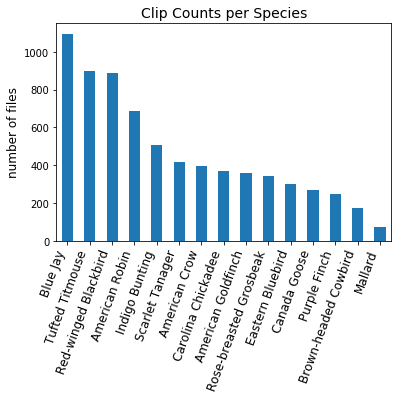

In [3]:
#import seaborn as sns
#import numpy as np
#import matplotlib.pyplot as plt

ax = data.species.value_counts().plot(kind='bar')
if 'all' in filename:
    fontsize = 6
else:
    fontsize=12
ax.xaxis.set_ticklabels(ax.xaxis.get_ticklabels(), rotation=70, ha='right', fontsize=fontsize )
ax.set_ylabel('number of files', fontsize=12)
ax.set_title('Clip Counts per Species', fontsize=14)

## Model Training Begins here:
- split the targets and the features
- perform one hot encoding, for other model comparison
- use a Gradient Boosting Classifier descision tree model
- plot the confusion matrix
- hyper-parameter tuning

In [4]:
#use OneHot encoding to transform categorical data into something useful
from sklearn.preprocessing import OneHotEncoder
#simple imputer will handle missing values
from sklearn.impute import SimpleImputer
#chain together multiple transformations in one custom filter
from sklearn.pipeline import Pipeline
#select (by column header/key) which columns get which kind of transformation
from sklearn.compose import ColumnTransformer

In [5]:
#choose which columns get transformed
cat_cols = ['species']
#create the pipeline
cat_si_step = ('si', SimpleImputer(strategy='constant',
                   fill_value='MISSING'))
cat_ohe_step = ('ohe', OneHotEncoder(sparse=False,
                    handle_unknown='ignore'))

#combine the two transformations into a single Pipeline
cat_steps = [cat_si_step, cat_ohe_step]
cat_pipe = Pipeline(cat_steps)

cat_transformers = [('cat', cat_pipe, cat_cols)]
ct = ColumnTransformer(transformers=cat_transformers)

target_fit_transformed = ct.fit_transform(data)
target_transformed = ct.transform(data) #fit shouldnt matter for one-hot encoding

pd.DataFrame( target_fit_transformed ).tail(6)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
7006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
7008,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7010,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [6]:
#remove the species column from the test dataframe
species_col = data.pop('species')

In [7]:
#get the feature names from the transformation
all_steps = ct.named_transformers_['cat']
ohe = all_steps.named_steps['ohe']
cat_feature_names = ohe.get_feature_names()
#clean up the feature names to make more readable
ohe_column_names = [cfn.strip('x0_').strip() for cfn in cat_feature_names]
cat_feature_names, ohe_column_names 

(array(['x0_American Crow', 'x0_American Goldfinch', 'x0_American Robin',
        'x0_Blue Jay', 'x0_Brown-headed Cowbird', 'x0_Canada Goose',
        'x0_Carolina Chickadee', 'x0_Eastern Bluebird',
        'x0_Indigo Bunting', 'x0_Mallard', 'x0_Purple Finch',
        'x0_Red-winged Blackbird', 'x0_Rose-breasted Grosbeak',
        'x0_Scarlet Tanager', 'x0_Tufted Titmouse'], dtype=object),
 ['American Crow',
  'American Goldfinch',
  'American Robin',
  'Blue Jay',
  'Brown-headed Cowbird',
  'Canada Goose',
  'Carolina Chickadee',
  'Eastern Bluebird',
  'Indigo Bunting',
  'Mallard',
  'Purple Finch',
  'Red-winged Blackbird',
  'Rose-breasted Grosbeak',
  'Scarlet Tanager',
  'Tufted Titmouse'])

Use stratified random sample for the test/train split
this will preserve species ratios of the data in train/test split

In [11]:
#write the resulting model parameters with joblib
from joblib import dump, load
dump(cbg, 'cbg_model_tuned.joblib') 
#load the model for testing
#cbg_loaded = load('cbg_model_150samples.joblib') 

['cbg_model_tuned.joblib']

In [8]:
#f1 score comparifon funtion
from sklearn.metrics import f1_score

def GetF1Scores( y_test, y_pred ):
    '''
    f1 = 2*prec*recall/(prec+recall)
    marco is the average f1 score across all species
    weighted is the weighted average of all f1 
        (i.e. taking the support number for each class into account)
    micro is the f1 computed with micro averaged prec and recall
        micro prec+recall are treating combining the results from all classes
    '''
    f1macro = f1_score(y_test, y_pred, average='macro')
    f1micro = f1_score(y_test, y_pred, average='micro')
    f1weighted = f1_score(y_test, y_pred, average='weighted')
    f1none = f1_score(y_test, y_pred, average=None)

    return f1macro, f1micro, f1weighted#, f1none

In [28]:
#string target
import numpy as np

X,y = np.array(data), np.array(species_col)

from sklearn.ensemble import GradientBoostingClassifier
#recalls
params_noBE = {'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 4, 'n_estimators': 125} #best params for 2_6 no bald
params_recall_2_6 = {'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 4, 'n_estimators': 150}
params_prec = {'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 4, 'n_estimators': 200} #prec hyper-tuned for v2 9_species
params = {'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 6, 'n_estimators': 150} #params hyper-tuned for v2 (9 birds 14 features)
cbg = GradientBoostingClassifier( **params_noBE )# **params_recall_2_6 )

In [ ]:
#try different under-sample resampling techniques
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids, NearMiss
##near miss under-sample
nm1 = NearMiss(version=1)
X_resampled, y_resampled = nm1.fit_resample(X, y)
##centroid cluster under-sample
#cc = ClusterCentroids(random_state=0)
#X_resampled, y_resampled = cc.fit_resample(X, y)
##random under-sample
#rus = RandomUnderSampler(random_state=0)
#X_resampled, y_resampled = rus.fit_resample(X, y)
pd.DataFrame( y_resampled )[0].value_counts(), pd.DataFrame(y)[0].value_counts()

In [19]:
#try different under-sample resampling techniques
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
##random over-sample (contains repeats...)
#ros = RandomOverSampler(random_state=0)
#X_resampled, y_resampled = ros.fit_resample(X, y)
##SMOTE -- Synthetic Minority Oversampling Technique 
X_resampled, y_resampled = SMOTE().fit_resample(X, y) #need to use only on test set
##ADASYN -- Adaptive Synthetic sampling method
#X_resampled, y_resampled = ADASYN().fit_resample(X, y) #need to use only on test set

pd.DataFrame( y_resampled )[0].value_counts(), pd.DataFrame(y)[0].value_counts(), len

(Canada Goose              1095
 American Crow             1095
 Indigo Bunting            1095
 Red-winged Blackbird      1095
 Purple Finch              1095
 Carolina Chickadee        1095
 Mallard                   1095
 American Goldfinch        1095
 Tufted Titmouse           1095
 American Robin            1095
 Eastern Bluebird          1095
 Blue Jay                  1095
 Scarlet Tanager           1095
 Brown-headed Cowbird      1095
 Rose-breasted Grosbeak    1095
 Name: 0, dtype: int64, Blue Jay                  1095
 Tufted Titmouse            899
 Red-winged Blackbird       886
 American Robin             687
 Indigo Bunting             505
 Scarlet Tanager            418
 American Crow              393
 Carolina Chickadee         367
 American Goldfinch         360
 Rose-breasted Grosbeak     343
 Eastern Bluebird           298
 Canada Goose               268
 Purple Finch               245
 Brown-headed Cowbird       174
 Mallard                     74
 Name: 0, dtype: 

In [34]:
#loop through a series of splits to score the model and check the consistency across splits
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.7, random_state=700) #145 userd for <200 #122 for <100 and<300
from sklearn.metrics import classification_report

ds = []
outdict = True
resample = True


for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    if resample:
        X_train, y_train = SMOTE().fit_resample(X_train, y_train)
    
    cbg.fit(X_train, y_train)
    y_pred = cbg.predict( X_test )
    #confusion_matrix = MakeConfusionMatrix( y_test, y_pred )
    #PrintConfusionMatrix(confusion_matrix.values, confusion_matrix.columns, normalize=True);
    print(GetF1Scores( y_test, y_pred ) )
    CR = classification_report(y_test, y_pred, output_dict=outdict )
    if not outdict:
        print( CR )
    ds.append( CR )#classification_report(y_test, y_pred))#, output_dict=True ) )

(0.6652933201538981, 0.6901609289060908, 0.6877824166168496)


base model (0.5725578383794906, 0.6369932776532898, 0.628740227785579)  
with tuned hyper parameters (0.6131641782474385, 0.6667345691586881, 0.6613292320174331)  
smote no hyper params (0.6312637316587801, 0.6453452841719292, 0.6455611182892493)  
smote plus hyper params (0.6652933201538981, 0.6901609289060908, 0.6877824166168496)

## model testing/verification

In [39]:
#get the results from the loop of splits

def GetReportResults( ds ):
    accuracies = [d['accuracy'] for d in ds]
    #macro scores
    macro_pres = [d['macro avg']['precision'] for d in ds]
    macro_recall = [d['macro avg']['recall'] for d in ds]
    macro_f1 = [d['macro avg']['f1-score'] for d in ds]
    macro_support = [d['macro avg']['support'] for d in ds]
    #weighted scores
    weighted_pres = [d['weighted avg']['precision'] for d in ds]
    weighted_recall = [d['weighted avg']['recall'] for d in ds]
    weighted_f1 = [d['weighted avg']['f1-score'] for d in ds]
    weighted_support = [d['weighted avg']['support'] for d in ds]
    print('avg accuracy: {:.3f}'.format( np.average(accuracies) ) )
    print('macro')
    print(' avg_prescision avg_recall avg_f1')
    print('{:.3} {:.3} {:.3}'.format( np.average(macro_pres), np.average(macro_recall), np.average(macro_f1)))
    print('weighted')
    print( '{:.3} {:.3} {:.3}'.format( np.average(weighted_pres), np.average(weighted_recall), np.average(weighted_f1)))

GetReportResults( ds )

avg accuracy: 0.690
macro
 avg_prescision avg_recall avg_macro
0.687 0.654 0.665
weighted
0.691 0.69 0.688


In [40]:
#f1 scores for default values
#they are actually worse...change the hyperparameter tuning properties...
GetF1Scores( y_test, y_pred )
y_pred.shape, y_test.shape

((4909,), (4909,))

In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#from sklearn.metrics import plot_confusion_matrix

def MakeConfusionMatrix( y_test, y_pred ):
    data = {'y_Actual':   y_test,
            'y_Predicted': y_pred
            }

    df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
    confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'], margins = True)
    
    print( confusion_matrix.shape )
    confusion_matrix = confusion_matrix[:-1]
    print( confusion_matrix.shape )
    confusion_matrix.drop(columns=['All'], inplace=True)
    

    ##plt.figure(figsize=(14,10))
    ##sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
    '''disp = plot_confusion_matrix(classifier, X_test, y_test,
                                     display_labels=class_names,
                                     cmap=plt.cm.Blues,
                                     normalize=True)'''
    # fix for mpl bug that cuts off top/bottom of seaborn viz
    #b, t = plt.ylim() # discover the values for bottom and top
    #b += 0.5 # Add 0.5 to the bottom
    #t -= 0.5 # Subtract 0.5 from the top
    ##plt.ylim(b, t) # update the ylim(bottom, top) values
    ##plt.show() # ta-da!
    return confusion_matrix

confusion_matrix = MakeConfusionMatrix( y_test, y_pred )
confusion_matrix.columns.shape
#confusion_matrix.values, confusion_matrix.columns

(16, 16)
(15, 16)


(15,)

(16, 16)
(15, 16)
Normalized confusion matrix
Confusion matrix, without normalization


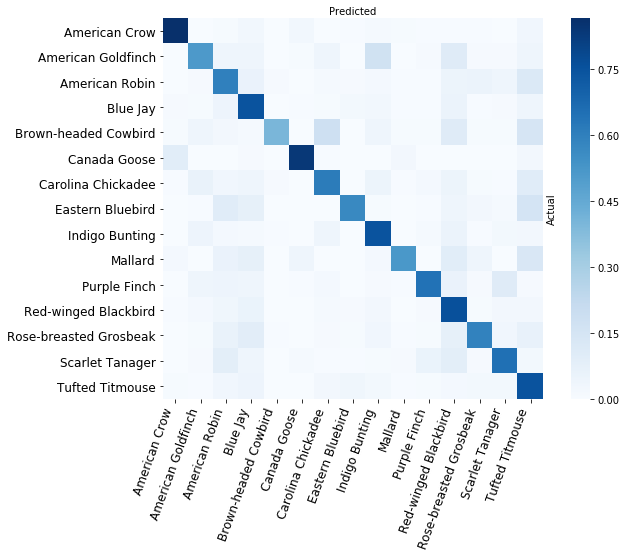

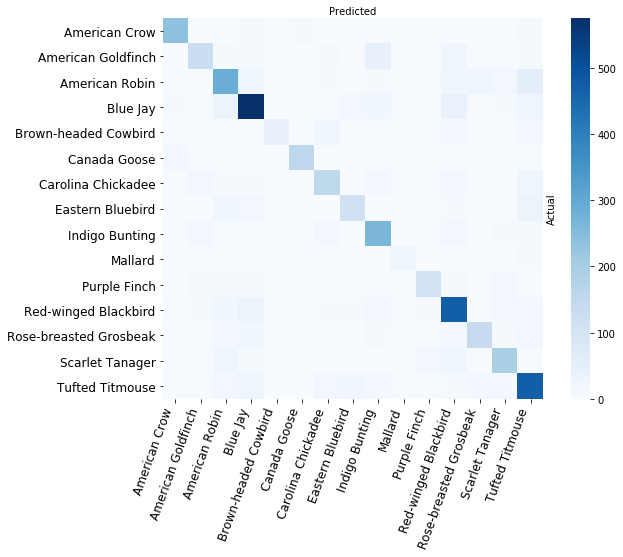

In [42]:
#modified from https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def print_confusion_matrix(confusion_matrix, class_names, normalize=False, figsize = (10,7), fontsize=12):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    if normalize:
        confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
        #print(confusion_matrix)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    fmt = '.2f' if normalize else 'd'
    
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    numbers = False
    try:
        heatmap = sns.heatmap(df_cm, annot=numbers, fmt=fmt, cmap='Blues', square=True, xticklabels=True, yticklabels=True)#, cbar_kws={'label': 'accuracy'})
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=70, ha='right', fontsize=fontsize)
    heatmap.yaxis.set_label_position('right')
    heatmap.xaxis.set_label_position('top')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    # fix for mpl bug that cuts off top/bottom of seaborn viz
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    return fig

if 'all' in filename:
    fontsize = 6
else:
    fontsize = 12
confusion_matrix = MakeConfusionMatrix( y_test, y_pred )
print_confusion_matrix(confusion_matrix.values, confusion_matrix.columns, normalize=True, fontsize=fontsize);
print_confusion_matrix(confusion_matrix.values, confusion_matrix.columns, fontsize=fontsize);

## Feature Importance

Text(0.5, 1.0, 'Feature Importance')

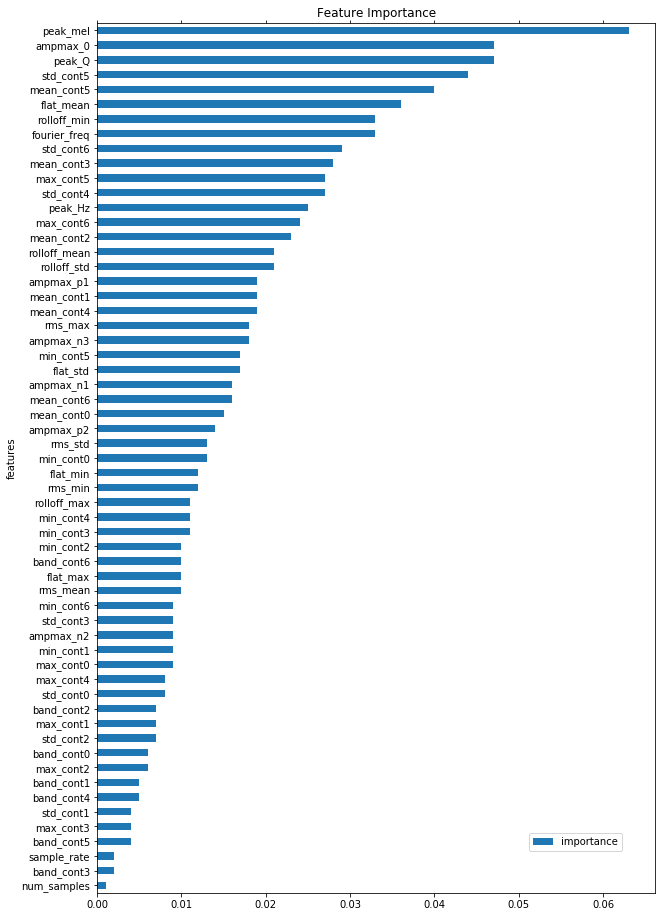

In [43]:
#plot the entire feature importance bar graph.
dfin = []
for feat,imp in sorted( zip(data.columns, cbg.feature_importances_), key=lambda l:l[1]):#, reverse=True):
    #zxprint(feat.strip(), '{:.3f}'.format(imp) )
    dfin.append( (feat.strip(), '{:.3f}'.format(imp)) )
df = pd.DataFrame(dfin)#.drop(np.arange(4,40))
df.columns = 'features', 'importance'
#df.set_index('features', drop=True, inplace=True)
df.importance = df.importance.astype(float)
f,ax = plt.subplots( figsize=(10,16) )
ax.get_xaxis().set_ticks_position('both')
#ax.get_xaxis().
df.plot.barh(x='features', y='importance', ax=ax ).legend(bbox_to_anchor=(0.95, 0.075))
ax.set_title( 'Feature Importance' )

Text(0.5, 1.0, 'Feature Importance')

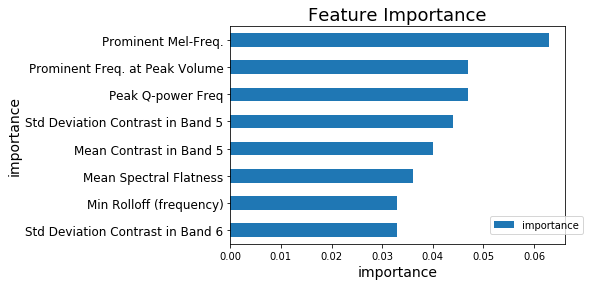

In [46]:
#only plot the top few features...
dfin = []
i=0
for feat,imp in sorted( zip(data.columns, cbg.feature_importances_), key=lambda l:l[1]):#, reverse=True):
    #zxprint(feat.strip(), '{:.3f}'.format(imp) )
    dfin.append( (feat.strip(), '{:.3f}'.format(imp)) )
    #if i==4: break
    #i+=1
    
df = pd.DataFrame(dfin)[-8:]#.drop(np.arange(4,40))
df.columns = 'features', 'importance'
#df.set_index('features', drop=True, inplace=True)/
df.importance = df.importance.astype(float)
f,ax = plt.subplots()#figsize=(10,16) )

df.plot.barh(x='features', y='importance', ax=ax ).legend(bbox_to_anchor=(0.76, 0.15))
#ax.set_yticklabels(reversed( ('Prominent Freq. at Peak Volume', 'Std Deviation Contrast in Band 6', 'Mean Contrast in Band 4', 'Std Deviation Contrast in Band 6', 'Max Contrast Band 6', 'Std Deviation Contrast in Band 5' ) ), fontsize=12)
ax.set_yticklabels(reversed( ('Prominent Mel-Freq.', 'Prominent Freq. at Peak Volume', 'Peak Q-power Freq', 'Std Deviation Contrast in Band 5', 'Mean Contrast in Band 5', 'Mean Spectral Flatness', 'Min Rolloff (frequency)', 'Std Deviation Contrast in Band 6' ) ), fontsize=12)
#corresponding = 'ampmax_0 std_cont6 mean_cont4 std_cont4 max_cont6 std_cont5'.split()
ax.set_ylabel('importance', fontsize=14)
ax.set_xlabel('importance', fontsize=14)
ax.set_title( 'Feature Importance', fontsize=18 )

In [ ]:
#check the classes trained by the model
#cbg.classes_

In [ ]:
feature_list = 'prominent frequency', 'prominent Q-power frequency', 'prominent mel-frequency'
data.columns

## hyper parameter tuning

In [ ]:
#hyperparameter tuning for gradient boost classifier
#modified from  https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV
tuned_parameters = {
    "loss":["deviance"], #, "exponential" requires 2 target classes (not-multi...)
    "learning_rate": [0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3],
    #"min_samples_split": np.linspace(0.1, 0.5, 12),
    #"min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[2,3,4,5],
    #"max_features":["log2","sqrt"],
    #"criterion": ["friedman_mse",  "mae"],
    #"subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[ 25, 50, 100, 125, 150]
    }

#score on prescision and recall...
#clf = GridSearchCV(GradientBoostingClassifier(), parameters, cv=10, n_jobs=-1)

scores = ['f1']# ['recall']
weight = 'weighted'
output = False

for score in scores:
    print(f'# Tuning hyper-parameters for {score}\n')
    #using macro scoring...try weighted after? ...for micro, prescision=acuracy...for multiclass
    clf = GridSearchCV(GradientBoostingClassifier(), tuned_parameters,
                       scoring=f'{score}_{weight}', cv=10, n_jobs=-1)
    #clf = GridSearchCV( svm.SVC(), tuned_parameters, scoring=f'{score}_macro' )
    clf.fit( X_train, y_train )
    print('best params found on development set\n')
    print( clf.best_params_ )
    if output:
        print('\ngrid scores on development set:')
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean,std,params in zip( means, stds, clf.cv_results_['params'] ):
            print('{:.3f} +/-{:.3f} for {}'.format( mean, 2*std, params) )
            print('classification report:\n')
            y_true, y_pred = y_test, clf.predict( X_test )
            print( classification_report(y_true, y_pred ) )
    

## ROC (Reciever Operator Curve)

In [ ]:
#Reciever operator curve for multi class classifier
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
#https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html#sklearn.multiclass.OneVsRestClassifier
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import StratifiedShuffleSplit

# Import some data to play with
##iris = datasets.load_iris()
##X = iris.data
##y = iris.target

# Binarize the output
##y = label_binarize(y, classes=[0, 1, 2])
y = label_binarize(y, classes=ohe_column_names )
n_classes = y.shape[1]

# Add noisy features to make the problem harder
random_state = np.random.RandomState(42)
#n_samples, n_features = X.shape
#X = np.c_[X, random_state.randn(n_samples, 20 * n_features)]

# shuffle and split training and test sets
##X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=0)
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.7, random_state=random_state)

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

# Learn to predict each class against the other
#classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
classifier = OneVsRestClassifier(GradientBoostingClassifier( random_state=random_state),n_jobs=-1)
                                 #random_state=random_state))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [ ]:
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

plotall = True
if plotall:
    ##colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    colors = cycle(['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink',
                    'tab:gray', 'tab:olive', 'tab:cyan'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.title('Receiver Operating Characteristic Curves')
plt.legend(loc="lower right", fontsize=8)
plt.show()